In [1]:
#Se entrenará una red neuronal que de la solución de dos ecuaciones diferenciales en [-5, 5]
#Se graficará la solución numérica junto con la analítica

#Inciso a) xy' + y = x^2cos(x). con y(0)=0

In [2]:
#Inciso b) d^2y/dx^2 = -y con y(0)=1, y'(0)= -0.5

In [16]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Reshape, Layer
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

Primera ecuación

In [18]:

class ODESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size, 1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
            tape.watch(x)
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training=True)
            dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
            x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
            y_o = self(x_o,training=True) #valor del modelo en en x_0
            eq = x*dy + y_pred - tf.math.cos(x)*x**2 #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
            ic = 0. #valor que queremos para la condicion inicial o el modelo en x_0
            loss = self.mse(tf.cast(0., tf.float32), eq) + self.mse(tf.cast(y_o, tf.float32),ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

In [19]:
model = ODEsolver()

model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))


model.summary()

Model: "od_esolver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                20        
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


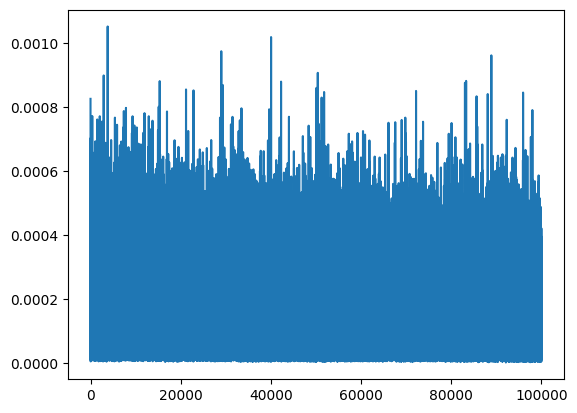

In [29]:
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=100000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 3ms/step


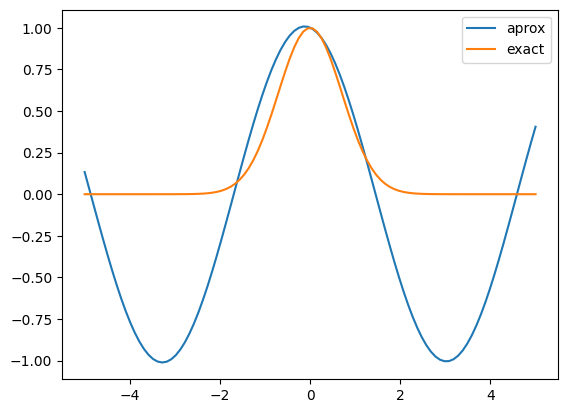

In [30]:

def sol1(x):
    return ((x**2 - 2)*np.sin(x))/x + 2*np.cos(x)

x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv,np.exp(-x*x),label="exact")
plt.legend()
plt.show()

In [23]:

class ODESolver2(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size, 1), minval=min, maxval=max)

         with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                with tf.GradientTape(persistent=True) as gg:
                    gg.watch(x)
                    y_pred = self(x, training=True)
                dy = gg.gradient(y_pred, x)
            ddy = g.gradient(dy, x)
            x_o = tf.zeros((batch_size,1))
            y_o1 = self(x_o, training=True)
            y_o2 = self(x_o, training=True)
            eq = ddy + y_pred
            ic1 = 1.
            ic2 = -0.5
            loss = self.mse(0., eq) + self.mse(y_o1, ic1)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

In [24]:

model = ODESolver2()

model.add(Dense(100, activation="tanh", input_shape=(1,)))
model.add(Dense(10, activation="tanh"))
model.add(Dense(1))

model.summary()

Model: "ode_solver2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               200       
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1221 (4.77 KB)
Trainable params: 1221 (4.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


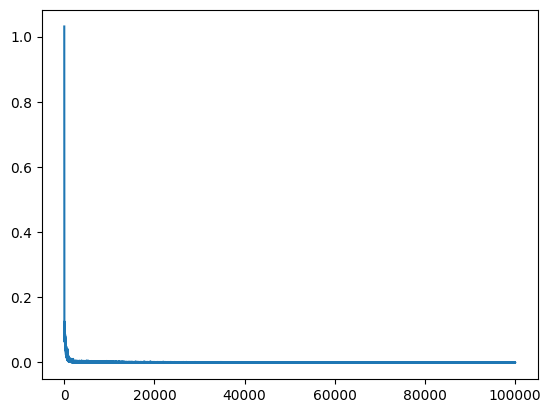

In [25]:
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=100000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 5ms/step


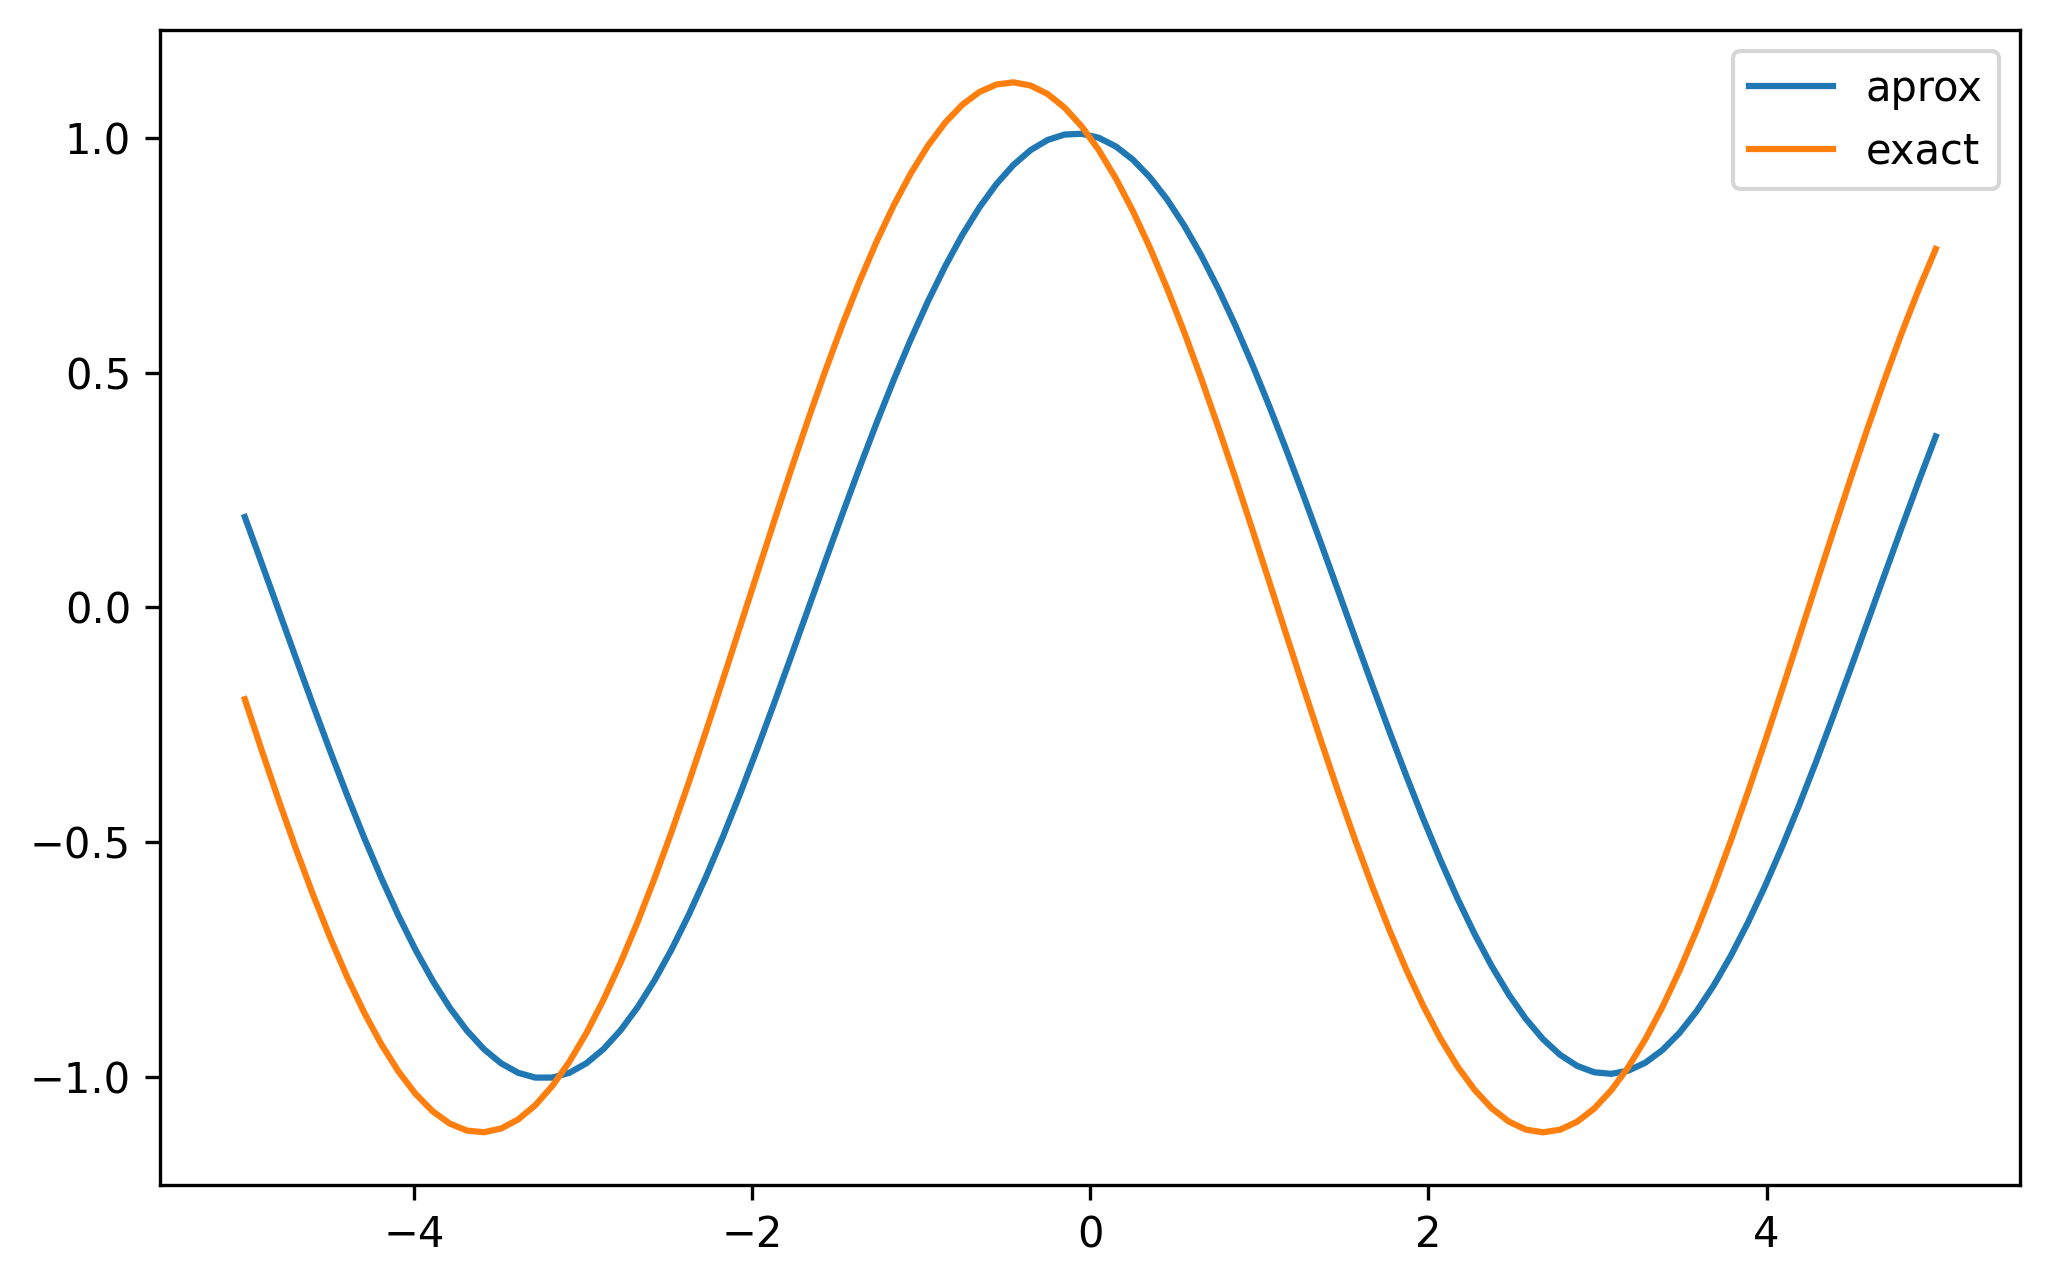

In [28]:

def sol2(x):
    return - 0.5*tf.math.sin(x) + tf.math.cos(x)

x_testv = tf.linspace(-5, 5,100)
a=model.predict(x_testv)
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv, sol2(x_testv), label="exact")
plt.legend()
